**Краткий отчет**

1) Реализован ноутбук для расчета 9 валидационных метрик над 4-мя датасетами.

2) Ноутбук настроен на расчет метрик для моделей Holter-Winter Smoothing, SARIMAX, Prophet.

3) Для оценки качества используется в том числе кросс-валидация. Реализован следующией интерфейчс для кросс-валидации:
offset - процент историчсеких наблюдений который используется для моделирования. Оставшаяся часть делится на n равных фолдов (n_fold),  от каждого фодда берется процент в тестовую выборку (атрибут test). Такой подход позволяет явно определять число фолдов (в Prophet такого параметра нет) и для каждого фолда более или менее одинаковая картина, что лучше для усреднения метрик.

4) Все запускалось в colab. Необходимость переустанавливать statsmodels - мой костыль, т.к. иначе в colab эта либа не работала.

5) Все датасеты доступны по адресу:

https://gitlab.com/mle-project/imitator-project/tree/master/benchmark/data

6) Итоговые значения метрик сведены в таблицу pivot.xlsx.




In [1]:
pip install fbprophet

In [2]:
pip install prophet

  Stored in directory: /root/.cache/pip/wheels/77/3e/f3/1c536bf1f871f818686e7fbf31cab18d52787a72dea8640756
Successfully built prophet


In [3]:
pip install ml_metrics

  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [4]:
pip uninstall statsmodels

Uninstalling statsmodels-0.9.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/statsmodels-0.9.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.9.0


In [5]:
pip install -U statsmodels

     |████████████████████████████████| 7.4MB 2.8MB/s 


In [0]:
import statsmodels
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import median_absolute_error
from sklearn.utils import check_array
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime
from fbprophet import Prophet
%matplotlib inline
plt.style.use('Solarize_Light2')

In [0]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
def MdAPE(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def sMAPE(actual, predicted):
    return 100 * np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def sMdAPE(actual, predicted):
    return 100 * np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def RMSPE(actual, predicted):
    return 100 * np.sqrt(np.mean(np.square((actual - predicted)/actual)))

def RMdSPE(actual: np.ndarray, predicted: np.ndarray):
    return 100 * np.sqrt(np.median(np.square((actual - predicted)/actual)))

**I. Загрузка данных**


Milk production

In [0]:
r = pd.read_csv('monthly-milk.csv', sep=';')
r.columns=['time', 'data']
r = r.set_index(['time'])
df = r.copy()

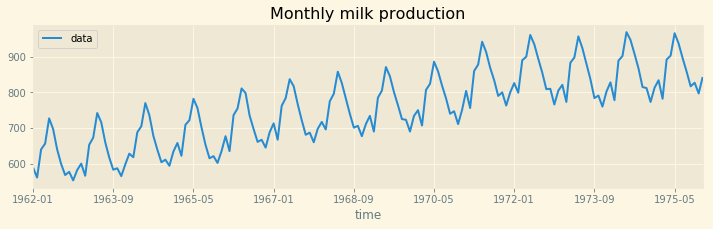

In [9]:
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));
plt.title('Monthly milk production');

AEP Hourly Energy Consumption

In [0]:
data_aep = pd.read_csv('AEP_hourly.csv')
aep = pd.DataFrame(data_aep, columns=['Datetime','AEP_MW']).set_index('Datetime')
aep.sort_index(inplace=True)

In [0]:
aep = aep.iloc[105000:]

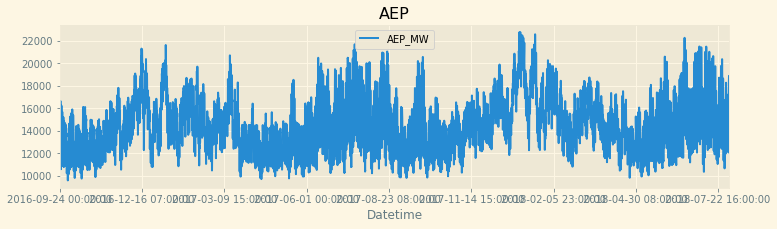

In [12]:
train_aep = aep.iloc[:-118, :]
test_aep = aep.iloc[-118:, :]
train_aep.index = pd.to_datetime(train_aep.index)
test_aep.index = pd.to_datetime(test_aep.index)
pred_aep = test_aep.copy()
aep.plot(figsize=(12,3));
plt.title('AEP');

Dow Jones Index

In [13]:
data_dj = pd.read_csv('DJ.csv', sep=';')
data_dj.columns = ['ds_','y']
data_dj.head(5)

ds_       y
0  1971-W27  890.19
1  1971-W28  901.80
2  1971-W29  888.51
3  1971-W30  887.78
4  1971-W31  858.43

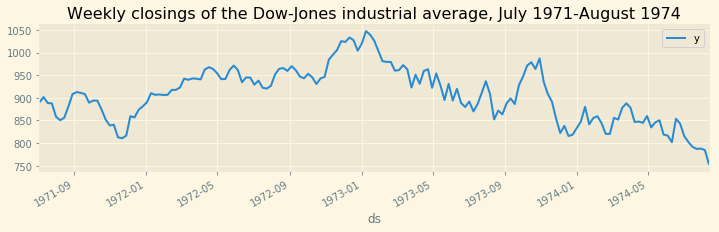

In [14]:
data_dj['ds'] = data_dj.reset_index().apply(lambda row: datetime.datetime.strptime(str(row['ds_']) + '-1', "%Y-W%W-%w"), axis=1)
data_dj = data_dj.drop(['ds_'], axis=1)
df_dj = data_dj.set_index('ds')
train_dj = df_dj.iloc[:-14, :]
test_dj = df_dj.iloc[-14:, :]
train_dj.index = pd.to_datetime(train_dj.index)
test_dj.index = pd.to_datetime(test_dj.index)
df_dj.plot(figsize=(12,3));
plt.title('Weekly closings of the Dow-Jones industrial average, July 1971-August 1974');

4) Monthly Australian Imports from Japan

In [0]:
#datelist = pd.date_range(pd.Timestamp('1965-01-01'), periods=336, freq='M').tolist()

In [16]:
au = pd.read_csv('import.csv', sep=';')
au.columns = ['time', 'data']
au = au.set_index('time')
au.head(3)

data
time               
'1965-01-01'  27418
'1965-02-28'  30592
'1965-03-31'  23910

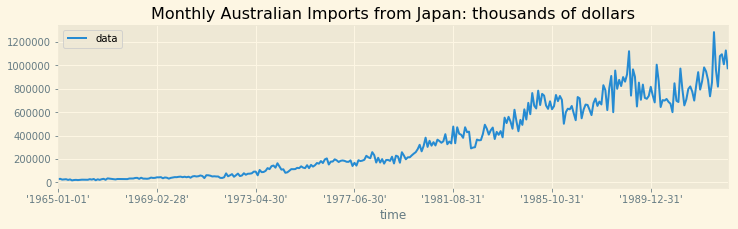

In [17]:
df_au = au.copy()
train_au = df_au.iloc[:-12, :]
test_au = df_au.iloc[-12:, :]
pred_au = test_au.copy()
df_au.plot(figsize=(12,3))
plt.title('Monthly Australian Imports from Japan: thousands of dollars');

**II. Моделирование  с помощью экспоненциального сглаживания**

1) Milk production

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end 

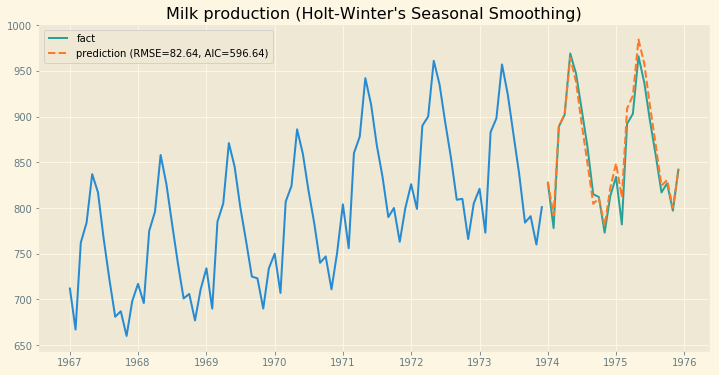

In [25]:
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("Milk production (Holt-Winter's Seasonal Smoothing)");

In [26]:
print('MSE, Test:', metrics.mse(test.values, pred.values))
print('RMSE, Test:', metrics.rmse(test.values, pred.values))
print('MAE, Test:', metrics.mae(test.values, pred.values))
print('RMSLE, Test:', metrics.rmsle(test.values, pred.values))
print('MAPE, Test:', MAPE(test.values.flatten(),pred.values.flatten()))
print('MdAPE, Test:', MdAPE(test.values.flatten(),pred.values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),pred.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),pred.values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),pred.values.flatten()))

MSE, Test: 6828.755896366316
RMSE, Test: 82.63628680166066
MAE, Test: 66.68131182826448
RMSLE, Test: 0.09477795667994138
MAPE, Test: 1.2243326442941538
MdAPE, Test: 1.1842249656212493
sMAPE, Test: 1.2170189096707045
sMdAPE, Test: 1.1826741477578355
RMSPE, Test: 1.524286966771256


2) AEP 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


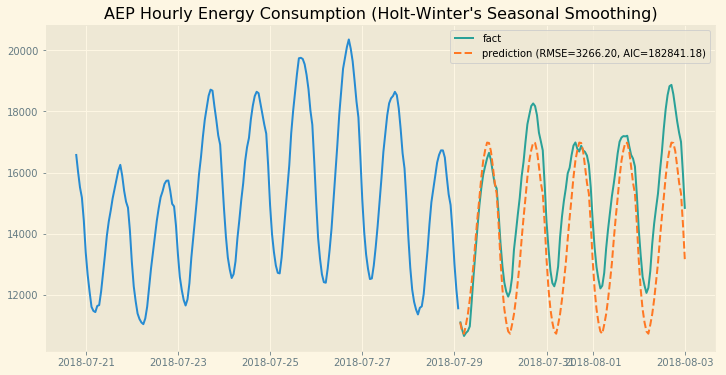

In [27]:
model_aep = ExponentialSmoothing(train_aep,seasonal='add', seasonal_periods=24)
fit = model_aep.fit()
pred_aep = fit.forecast(test_aep.shape[0])
sse1 = np.sqrt(np.mean(np.square(test_aep.values - pred_aep.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_aep.index[train_aep.shape[0] - 200:], train_aep.values[train_aep.shape[0] - 200:]);
ax.plot(test_aep.index, test_aep.values, label='fact');
ax.plot(test_aep.index, pred_aep, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("AEP Hourly Energy Consumption (Holt-Winter's Seasonal Smoothing)");

In [28]:
print('MSE, Test:', metrics.mse(test_aep.values, pred_aep.values))
print('RMSE, Test:', metrics.rmse(test_aep.values, pred_aep.values))
print('MAE, Test:', metrics.mae(test_aep.values, pred_aep.values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, pred_aep.values))
print('MAPE, Test:', MAPE(test_aep.values.flatten(),pred_aep.values.flatten()))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),pred_aep.values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),pred_aep.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),pred_aep.values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),pred_aep.values.flatten()))

MSE, Test: 10668068.89946244
RMSE, Test: 3266.2009888343428
MAE, Test: 2656.253179505454
RMSLE, Test: 0.23220016577219485
MAPE, Test: 8.410948607322306
MdAPE, Test: 8.454045668869698
sMAPE, Test: 8.900701420832164
sMdAPE, Test: 8.827172273019965
RMSPE, Test: 9.737476649555331


3) DJ

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


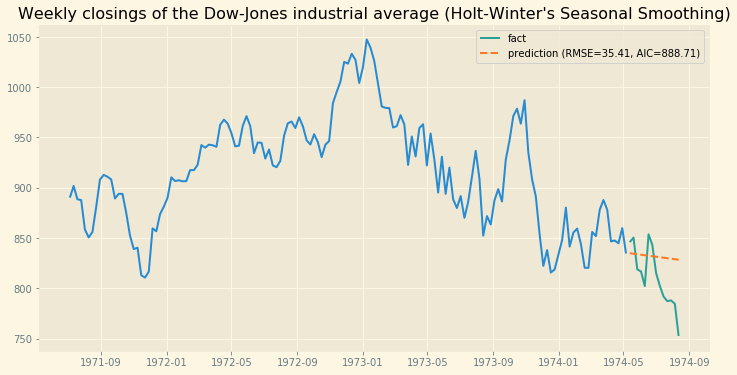

In [29]:
model_dj = ExponentialSmoothing(train_dj['y'], trend='mul', seasonal=None)
fit_dj = model_dj.fit()
pred_dj = fit_dj.forecast(14)

sse1 = np.sqrt(np.mean(np.square(test_dj.values - pred_dj.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_dj.index, train_dj.values);
ax.plot(test_dj.index, test_dj.values, label='fact');
ax.plot(test_dj.index, pred_dj, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit_dj.aic));
ax.legend();
ax.set_title("Weekly closings of the Dow-Jones industrial average (Holt-Winter's Seasonal Smoothing)");

In [30]:
print('MSE, Test:', metrics.mse(test_dj.values, pred_dj.values))
print('RMSE, Test:', metrics.rmse(test_dj.values, pred_dj.values))
print('MAE, Test:', metrics.mae(test_dj.values, pred_dj.values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, pred_dj.values))
print('MAPE, Test:', MAPE(test_dj.values.flatten(),pred_dj.values.flatten()))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),pred_dj.values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),pred_dj.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),pred_dj.values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),pred_dj.values.flatten()))

MSE, Test: 1254.1323393312312
RMSE, Test: 35.41373094339583
MAE, Test: 30.255242846636186
RMSLE, Test: 0.04387408651666139
MAPE, Test: 3.6820279547981762
MdAPE, Test: 3.024329451910505
sMAPE, Test: 3.599367371175814
sMdAPE, Test: 3.0091126155391152
RMSPE, Test: 4.362771658426303


4) Australian import

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


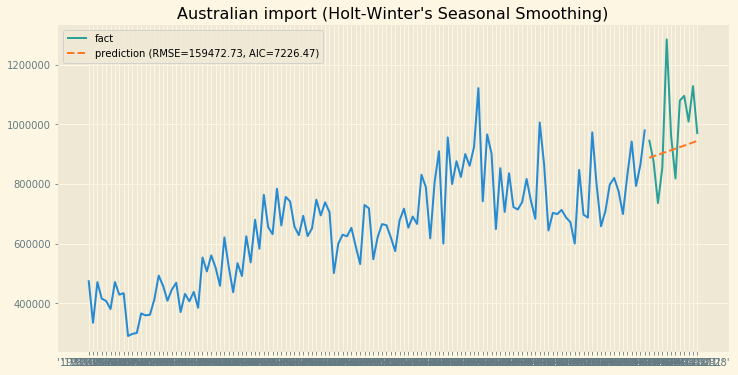

In [31]:
model_au = ExponentialSmoothing(train_au['data'], trend='mul', seasonal=None)
fit_au = model_au.fit()
pred_au = fit_au.forecast(12)

sse1 = np.sqrt(np.mean(np.square(test_au.values - pred_au.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_au.index[200:], train_au.values[200:]);
ax.plot(test_au.index, test_au.values, label='fact');
ax.plot(test_au.index, pred_au, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit_au.aic));
ax.legend();
ax.set_title("Australian import (Holt-Winter's Seasonal Smoothing)");

In [32]:
print('MSE, Test:', metrics.mse(test_au.values, pred_au.values))
print('RMSE, Test:', metrics.rmse(test_au.values, pred_au.values))
print('MAE, Test:', metrics.mae(test_au.values, pred_au.values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, pred_au.values))
print('MAPE, Test:', MAPE(test_au.values.flatten(),pred_au.values.flatten()))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),pred_au.values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),pred_au.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),pred_au.values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),pred_au.values.flatten()))

MSE, Test: 25431550272.143105
RMSE, Test: 159472.72579392095
MAE, Test: 127132.92348310674
RMSLE, Test: 0.15938056952650578
MAPE, Test: 11.569397207600796
MdAPE, Test: 9.821463938160688
sMAPE, Test: 12.11399370574652
sMdAPE, Test: 9.615248061267717
RMSPE, Test: 14.070209541609458


** III.  Моделирование с помощью Seasonal ARIMA**

1) Milk Production

In [0]:
def check_ts_is_stationary(df,column_name,pval=0.05):
    if adfuller(df[column_name])[1] < pval:
        print('Time series is stationary',  adfuller(df[column_name])[1])
    else:
        print('Time series is not stationary',  adfuller(df[column_name])[1])       

In [0]:
def diff_time_series(df, column_name, order=1):
    df['diff' + '_' + str(order)] = df[column_name] - df[column_name].shift(order)
    return df.dropna()   

In [35]:
check_ts_is_stationary(df, 'data')

Time series is not stationary 0.6274267086030337


Дифферинцируем

In [0]:
df_diff = diff_time_series(df, 'data')

In [37]:
check_ts_is_stationary(df_diff.dropna(),'diff_1')

Time series is stationary 0.030068004001782334


In [38]:
model = sm.tsa.statespace.SARIMAX(df['data'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                                 Statespace Model Results                                 
Dep. Variable:                               data   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Sun, 05 May 2019   AIC                           1074.131
Time:                                    20:11:32   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

In [0]:
pred_arima = results.predict('1974-01-01','1975-12-01')

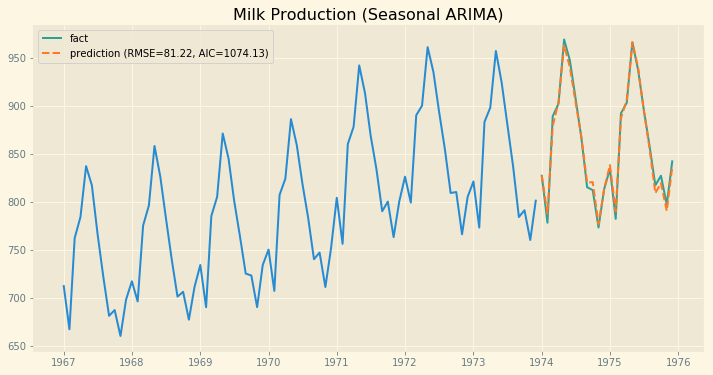

In [40]:
sse1 = np.sqrt(np.mean(np.square(test.values - pred_arima.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, pred_arima, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, results.aic));
ax.legend();
ax.set_title("Milk Production (Seasonal ARIMA)");

In [41]:
print('MSE, Test:', metrics.mse(test.values, pred_arima.values))
print('RMSE, Test:', metrics.rmse(test.values, pred_arima.values))
print('MAE, Test:', metrics.mae(test.values, pred_arima.values))
print('RMSLE, Test:', metrics.rmsle(test.values, pred_arima.values))
print('MAPE, Test:', MAPE(test.values.flatten(),pred_arima.values.flatten()))
print('MdAPE, Test:', MdAPE(test.values.flatten(),pred_arima.values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),pred_arima.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),pred_arima.values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),pred_arima.values.flatten()))

MSE, Test: 6596.038328291459
RMSE, Test: 81.21599798248778
MAE, Test: 65.55667858871254
RMSLE, Test: 0.09358986514687893
MAPE, Test: 0.5473568805657424
MdAPE, Test: 0.5335024715762996
sMAPE, Test: 0.5476669860952011
sMdAPE, Test: 0.5337023449331626
RMSPE, Test: 0.6602243508359515


2) AEP Hourly Energy Consumption

In [42]:
model_aep = sm.tsa.statespace.SARIMAX(train_aep['AEP_MW'],order=(1,1,2), seasonal_order=(1,1,1,24))
results_aep = model_aep.fit()
print(results_aep.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             AEP_MW   No. Observations:                16155
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 24)   Log Likelihood             -104240.214
Date:                            Sun, 05 May 2019   AIC                         208492.429
Time:                                    20:13:23   BIC                         208538.560
Sample:                                         0   HQIC                        208507.680
                                          - 16155                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4417      0.020     22.502      0.000       0.403       0.480
ma.L1          0.1696      0.020   

In [43]:
pred_arima_aep = results_aep.predict(train_aep.shape[0] -1, train_aep.shape[0] +test_aep.shape[0]-2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


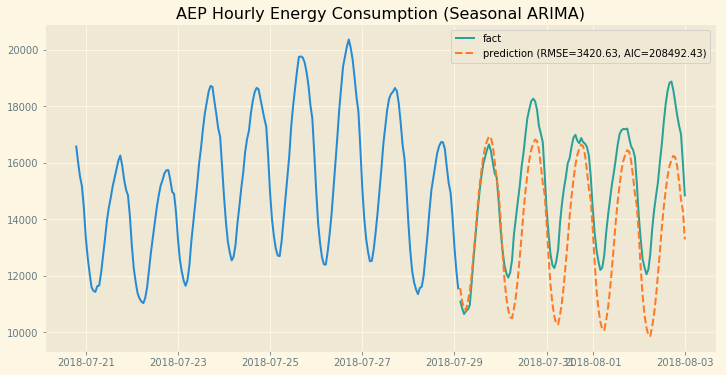

In [44]:
sse1 = np.sqrt(np.mean(np.square(test_aep.values - pred_arima_aep.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_aep.index[train_aep.shape[0] - 200:], train_aep.values[train_aep.shape[0] - 200:]);
ax.plot(test_aep.index, test_aep.values, label='fact');
ax.plot(test_aep.index, pred_arima_aep, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, results_aep.aic));
ax.legend();
ax.set_title("AEP Hourly Energy Consumption (Seasonal ARIMA)");

In [45]:
print('MSE, Test:', metrics.mse(test_aep.values, pred_arima_aep.values))
print('RMSE, Test:', metrics.rmse(test_aep.values, pred_arima_aep.values))
print('MAE, Test:', metrics.mae(test_aep.values, pred_arima_aep.values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, pred_arima_aep.values))
print('MAPE, Test:', MAPE(test_aep.values.flatten(),pred_arima_aep.values.flatten()))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),pred_arima_aep.values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),pred_arima_aep.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),pred_arima_aep.values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),pred_arima_aep.values.flatten()))

MSE, Test: 11700738.154766979
RMSE, Test: 3420.6341743552434
MAE, Test: 2778.9676622439715
RMSLE, Test: 0.24776526326640588
MAPE, Test: 10.228772867886015
MdAPE, Test: 9.511718865970195
sMAPE, Test: 11.069837893850696
sMdAPE, Test: 9.98668008174061
RMSPE, Test: 12.446741441375131


3) Dow-Johnson Index

In [47]:
model_dj = sm.tsa.statespace.SARIMAX(train_dj['y'], order=(1,1,2), 
                                     seasonal_order=(1,1,1,24),enforce_stationarity=False,
                                    enforce_invertibility=False)
results_dj = model_dj.fit()
print(results_dj.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  148
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 24)   Log Likelihood                -438.567
Date:                            Sun, 05 May 2019   AIC                            889.134
Time:                                    20:14:29   BIC                            904.520
Sample:                                         0   HQIC                           895.354
                                            - 148                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6164      0.331     -1.861      0.063      -1.266       0.033
ma.L1          0.5484      0.338   

In [48]:
 pred_arima_dj = results_dj.predict(train_dj.shape[0] -1, 
                                    train_dj.shape[0] +test_dj.shape[0]-2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


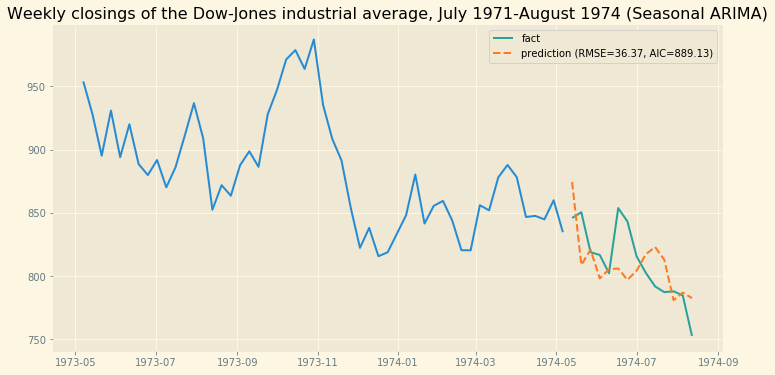

In [49]:
sse1 = np.sqrt(np.mean(np.square(test_dj.values - pred_arima_dj.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_dj.index[train_dj.shape[0] - 200:], train_dj.values[train_dj.shape[0] - 200:]);
ax.plot(test_dj.index, test_dj.values, label='fact');
ax.plot(test_dj.index, pred_arima_dj, linestyle='--', color='#ff7823', 
        label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, results_dj.aic));
ax.legend();
ax.set_title("Weekly closings of the Dow-Jones industrial average, July 1971-August 1974 (Seasonal ARIMA)");

In [50]:
print('MSE, Test:', metrics.mse(test_dj.values, pred_arima_dj.values))
print('RMSE, Test:', metrics.rmse(test_dj.values, pred_arima_dj.values))
print('MAE, Test:', metrics.mae(test_dj.values, pred_arima_dj.values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, pred_arima_dj.values))
print('MAPE, Test:', MAPE(test_dj.values.flatten(),pred_arima_dj.values.flatten()))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),pred_arima_dj.values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),pred_arima_dj.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),pred_arima_dj.values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),pred_arima_dj.values.flatten()))

MSE, Test: 1322.9738636722543
RMSE, Test: 36.37270767584198
MAE, Test: 29.01215170881366
RMSLE, Test: 0.044583890570660284
MAPE, Test: 2.6996452217431024
MdAPE, Test: 2.762919797301859
sMAPE, Test: 2.7138186067001073
sMdAPE, Test: 2.7500701522650224
RMSPE, Test: 3.273011268533157


4) Australian monthly import

In [51]:
model_au = sm.tsa.statespace.SARIMAX(train_au['data'], order=(1,1,2), seasonal_order=(1,1,1,24))
results_au = model_au.fit()
print(results_au.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                               data   No. Observations:                  328
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 24)   Log Likelihood               -3766.053
Date:                            Sun, 05 May 2019   AIC                           7544.106
Time:                                    20:14:42   BIC                           7566.389
Sample:                                         0   HQIC                          7553.021
                                            - 328                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1707      0.394      0.433      0.665      -0.602       0.943
ma.L1         -0.9840      0.386   

In [52]:
pred_arima_au =  results_au.predict(train_au.shape[0] -1, train_au.shape[0] +test_au.shape[0]-2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


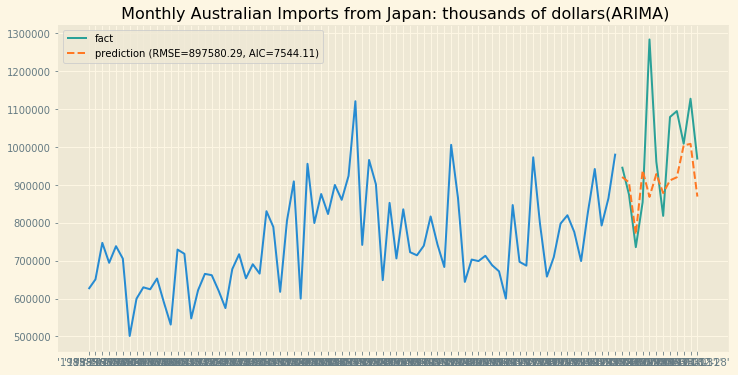

In [53]:
sse1 = np.sqrt(np.mean(np.square(test_aep.values - pred_arima_au.values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_au.index[250:], train_au.values[250:]);
ax.plot(test_au.index, test_au.values, label='fact');
ax.plot(test_au.index, pred_arima_au, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, results_au.aic));
ax.legend();
ax.set_title(" Monthly Australian Imports from Japan: thousands of dollars(ARIMA)");

In [54]:
print('MSE, Test:', metrics.mse(test_au.values, pred_arima_au.values))
print('RMSE, Test:', metrics.rmse(test_au.values, pred_arima_au.values))
print('MAE, Test:', metrics.mae(test_au.values, pred_arima_au.values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, pred_arima_au.values))
print('MAPE, Test:', MAPE(test_au.values.flatten(),pred_arima_au.values.flatten()))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),pred_arima_au.values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),pred_arima_au.values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),pred_arima_au.values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),pred_arima_au.values.flatten()))

MSE, Test: 29472840487.201458
RMSE, Test: 171676.5577683845
MAE, Test: 136287.45959367027
RMSLE, Test: 0.1748832186897611
MAPE, Test: 9.726788169980537
MdAPE, Test: 8.605833358890663
sMAPE, Test: 10.499250492066658
sMdAPE, Test: 8.243997205408043
RMSPE, Test: 12.787470566351605


** IV. Моделирование с помощью FBProphet**



**1. Milk Production**

In [0]:
from fbprophet import Prophet

In [0]:
train_fb = train.reset_index()
train_fb.columns = ['ds','y']

In [57]:
m = Prophet()
m.fit(train_fb)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future)

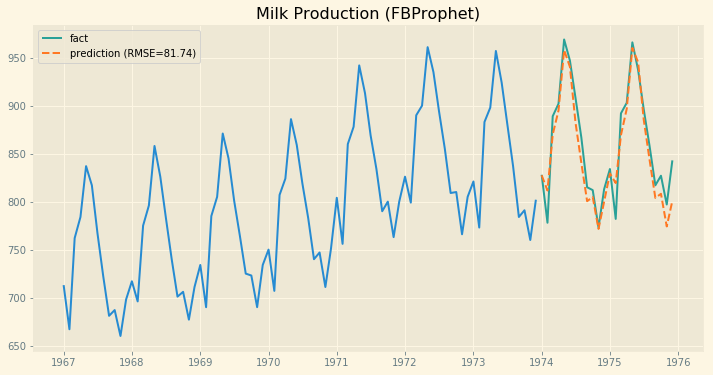

In [59]:
sse1 = np.sqrt(np.mean(np.square(test.values - forecast.yhat.iloc[-24:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, forecast.yhat.iloc[-24:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("Milk Production (FBProphet)");

In [60]:
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-24:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-24:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-24:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-24:].values))
print('MAPE, Test:', MAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))

MSE, Test: 6681.302218850347
RMSE, Test: 81.73923304540084
MAE, Test: 65.87173396485302
RMSLE, Test: 0.09431917393109336
MAPE, Test: 1.8383994790616147
MdAPE, Test: 1.6029665110658127
sMAPE, Test: 1.8474966223839397
sMdAPE, Test: 1.6159179352279494
RMSPE, Test: 2.289661913897465


**2) AEP**

In [0]:
train_fb_aep = train_aep.reset_index()
train_fb_aep.columns = ['ds','y']

In [0]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01','2015-01-01','2016-01-01', '2017-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2016-01-18', '2017-01-16'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2016-02-15', '2017-02-20'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2016-05-30', '2017-05-29'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2014-07-04','2015-07-04', '2016-07-04', '2017-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2015-09-07', '2016-09-05', '2017-09-04'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2015-10-12', '2016-10-10', '2017-10-09'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2014-11-11','2015-11-11', '2016-11-11', '2017-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2014-12-25','2015-12-25', '2016-12-25','2017-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

In [63]:
m_aep = Prophet(yearly_seasonality=True, weekly_seasonality=True,holidays=us_public_holidays)
m_aep.fit(train_fb_aep)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


In [0]:
future = m_aep.make_future_dataframe(periods=test_aep.shape[0],freq='H')
forecast = m_aep.predict(future)

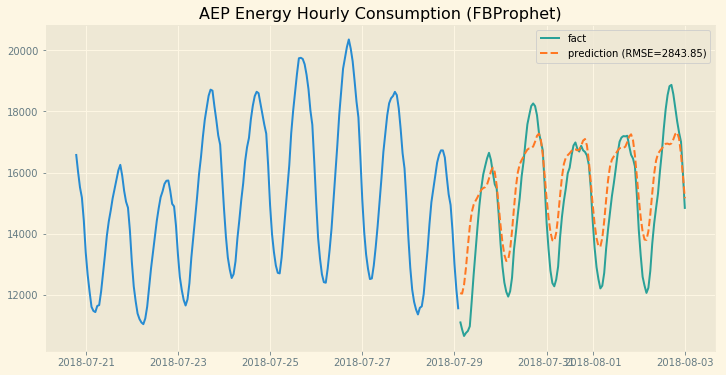

In [65]:
sse1 = np.sqrt(np.mean(np.square(test_aep.values - forecast.yhat.iloc[test_aep.shape[0]:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_aep.index[train_aep.shape[0] - 200:], train_aep.values[train_aep.shape[0] - 200:]);
ax.plot(test_aep.index, test_aep.values, label='fact');
ax.plot(test_aep.index, forecast.yhat.iloc[-test_aep.shape[0]:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("AEP Energy Hourly Consumption (FBProphet)");

In [67]:
print('MSE, Test:', metrics.mse(test_aep.values, forecast.yhat.iloc[-118:].values))
print('RMSE, Test:', metrics.rmse(test_aep.values, forecast.yhat.iloc[-118:].values))
print('MAE, Test:', metrics.mae(test_aep.values, forecast.yhat.iloc[-118:].values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, forecast.yhat.iloc[-118:].values))
print('MAPE, Test:', MAPE(test_aep.values.flatten(),forecast.yhat.iloc[-118:].values.flatten()))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-118:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),forecast.yhat.iloc[-118:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-118:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),forecast.yhat.iloc[-118:].values.flatten()))

MSE, Test: 6621453.809060837
RMSE, Test: 2573.2185700132113
MAE, Test: 2070.3300060333
RMSLE, Test: 0.17658295436932156
MAPE, Test: 6.749201496948906
MdAPE, Test: 5.924158618590611
sMAPE, Test: 6.457662600031679
sMdAPE, Test: 5.75361824011094
RMSPE, Test: 8.751537500400495


**3) DJIA**

In [0]:
train_fb_dj = train_dj.reset_index()
train_fb_dj.columns = ['ds','y']

In [69]:
m = Prophet(weekly_seasonality=True,yearly_seasonality=True,holidays=us_public_holidays)
m.fit(train_fb_dj)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=14,freq='W')
forecast = m.predict(future)

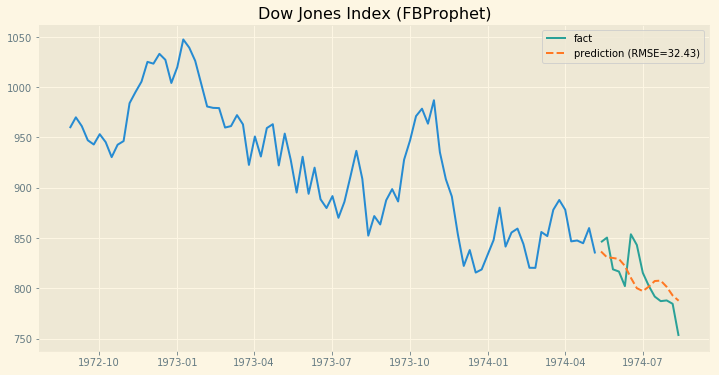

In [71]:
sse1 = np.sqrt(np.mean(np.square(test_dj.values - forecast.yhat.iloc[-14:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_dj.index[60:], train_dj.values[60:]);
ax.plot(test_dj.index, test_dj.values, label='fact');
ax.plot(test_dj.index, forecast.yhat.iloc[-14:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("Dow Jones Index (FBProphet)");

In [72]:
print('MSE, Test:', metrics.mse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSE, Test:', metrics.rmse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAE, Test:', metrics.mae(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAPE, Test:', MAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))

MSE, Test: 1051.95179003632
RMSE, Test: 32.43380628351104
MAE, Test: 26.632202882222735
RMSLE, Test: 0.040021164049318485
MAPE, Test: 2.378380814115769
MdAPE, Test: 2.0906650355230427
sMAPE, Test: 2.3850160903602498
sMdAPE, Test: 2.093775037518444
RMSPE, Test: 2.8036082390159494


**4) Australian import**

In [0]:
train_fb_au = train_au.reset_index()
train_fb_au.columns = ['ds','y']
#train_fb_au['y'] = np.log(train_fb_au['y'])

In [74]:
m_au = Prophet(seasonality_mode = 'multiplicative',yearly_seasonality=True,)
m_au.fit(train_fb_au)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m_au.make_future_dataframe(periods=12,freq='M')
forecast = m_au.predict(future)

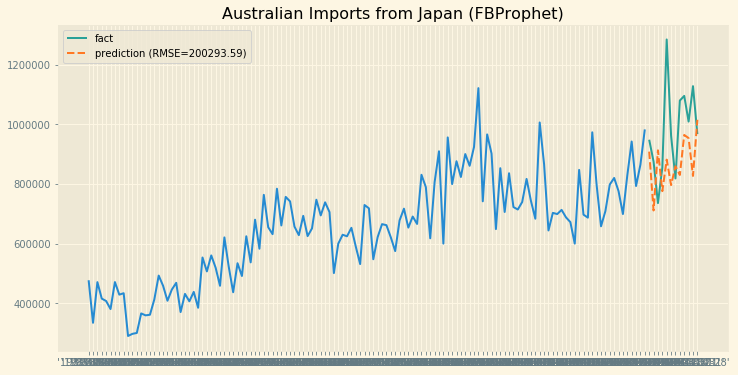

In [76]:
sse1 = np.sqrt(np.mean(np.square(test_au.values - forecast.yhat.iloc[-12:].values)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_au.index[200:], train_au.values[200:]);
ax.plot(test_au.index, test_au.values, label='fact');
ax.plot(test_au.index, forecast.yhat.iloc[-12:].values, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f})".format(sse1));
ax.legend();
ax.set_title("Australian Imports from Japan (FBProphet)");

In [77]:
print('MSE, Test:', metrics.mse(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSE, Test:', metrics.rmse(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAE, Test:', metrics.mae(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAPE, Test:', MAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))

MSE, Test: 40117520633.53861
RMSE, Test: 200293.58610184854
MAE, Test: 158910.34434091672
RMSLE, Test: 0.2098419667048001
MAPE, Test: 15.163756825433964
MdAPE, Test: 14.588195615473362
sMAPE, Test: 16.425602479144374
sMdAPE, Test: 15.779365113311943
RMSPE, Test: 17.746938281353085


**V. Кроссвалидация**

In [0]:
def train_test_val_split_v3(df,n_fold=3, test=0.5, offset = 0.7):
    
    N = df.shape[0]
    shift = np.floor(N*offset)
    T  = np.floor((N - shift) /n_fold)
    
    train_start_idx = [0  for k in range(n_fold)]
    train_finish_idx = [0 + shift + k * T - np.floor(T * test) + T  for k in range(n_fold)]
    
    test_start_idx = [0 + shift + k * T - np.floor(T * test) + T + 1 for k in range(n_fold)]
    test_finish_idx = [0 + shift + (k + 1) * T - 1 for k in range(n_fold)]
     
    train_idx = list(zip(map(int,train_start_idx),map(int,train_finish_idx)))
    test_idx = list(zip(map(int,test_start_idx),map(int,test_finish_idx)))
    
    train_df = [df.iloc[train_idx[i][0]:train_idx[i][1]] for i in range(len(train_idx))]
    test_df = [df.iloc[test_idx[i][0]:test_idx[i][1]] for i in range(len(test_idx))]
    
    return list(zip(train_df, test_df))

In [0]:
def cv_exp(df, n_fold=3, test=0.5, offset=0.7, title='', trend='add', seasonal='add', 
           seasonal_periods=12, plot=False):
    tts = train_test_val_split_v3(df,n_fold=n_fold, test=test, offset=offset)
    res = {}
    rmse = []
    mse = []
    mae = []
    rmsle = []
    mape = []
    mdape = []
    smape = []
    smdape = []
    rmpse = []
    for data in tts:
        model = ExponentialSmoothing(data[0].values, trend=trend, seasonal=seasonal, 
                                     seasonal_periods=seasonal_periods)
        fit = model.fit()
        pred = fit.predict(data[0].shape[0], data[0].shape[0] + data[1].shape[0] -1)
        rmse.append(metrics.rmse(pred, data[1].values))
        mse.append(metrics.mse(data[1], pred))
        mae.append(metrics.mae(data[1], pred))
        rmsle.append(metrics.rmsle(data[1], pred))
        mape.append(MAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        mdape.append(MdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smape.append(sMAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smdape.append(sMdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        rmpse.append(RMSPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        if plot:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.plot(data[0].index[data[0].shape[0] - 250:], data[0].values[data[0].shape[0] - 250:]);
            ax.plot(data[1].index, data[1].values, label='fact');
            ax.plot(data[1].index, pred, linestyle='--', color='#ff7823', 
                    label="prediction(RMSE={:0.2f})".format(metrics.rmse(pred, data[1].values)));
            ax.legend();
            ax.set_title(title  + " (Holt-Winter's Seasonal Smoothing)");
        res['rmse'] = np.mean(rmse)
        res['mse'] = np.mean(mse)
        res['mae'] = np.mean(mae)
        res['rmsle'] = np.mean(rmsle)
        res['mape'] = np.mean(mape)
        res['mdape'] = np.mean(mdape)
        res['smape'] = np.mean(smape)
        res['smdape'] = np.mean(smdape)
        res['rmpse']  = np.mean(rmpse)
    return res

In [0]:
def cv_sarimax(df, title='',n_fold=3, test=0.5, offset=0.7, 
               order=(0,1,0), seasonal_order=(1,1,1,12),
               enforce_stationarity=True, enforce_invertibility=True,
               plot=False):
    tts = train_test_val_split_v3(df,n_fold=n_fold, test=test, offset=offset)
    res = {}
    rmse = []
    mse = []
    mae = []
    rmsle = []
    mape = []
    mdape = []
    smape = []
    smdape = []
    rmpse = []
    for data in tts:
             
        model = sm.tsa.statespace.SARIMAX(data[0].values, 
                                          order=order, 
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=enforce_stationarity,
                                          enforce_invertibility=enforce_invertibility
                                         )
        fit = model.fit()
        pred = fit.predict(data[0].shape[0], data[0].shape[0] + data[1].shape[0] -1)
        rmse.append(metrics.rmse(pred, data[1].values))
        mse.append(metrics.mse(data[1], pred))
        mae.append(metrics.mae(data[1], pred))
        rmsle.append(metrics.rmsle(data[1], pred))
        mape.append(MAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        mdape.append(MdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smape.append(sMAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smdape.append(sMdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        rmpse.append(RMSPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        if plot:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.plot(data[0].index[data[0].shape[0] - 250:], data[0].values[data[0].shape[0] - 250:]);
            ax.plot(data[1].index, data[1].values, label='fact');
            ax.plot(data[1].index, pred, linestyle='--', color='#ff7823', 
                    label="prediction(RMSE={:0.2f})".format(metrics.rmse(pred, data[1].values)));
            ax.legend();
            ax.set_title(title + " (SARIMAX)");
        res['rmse'] = np.mean(rmse)
        res['mse'] = np.mean(mse)
        res['mae'] = np.mean(mae)
        res['rmsle'] = np.mean(rmsle)
        res['mape'] = np.mean(mape)
        res['mdape'] = np.mean(mdape)
        res['smape'] = np.mean(smape)
        res['smdape'] = np.mean(smdape)
        res['rmpse']  = np.mean(rmpse)
    return res

In [0]:
def cv_prophet(df,freq, title='',n_fold=3, test=0.5, offset=0.7,
               weekly_seasonality=False, seasonality_mode = 'additive',
               yearly_seasonality=True,
               plot=False):
  
    tts = train_test_val_split_v3(df,n_fold=n_fold, test=test, offset=offset)
    res = {}
    rmse = []
    mse = []
    mae = []
    rmsle = []
    mape = []
    mdape = []
    smape = []
    smdape = []
    rmpse = []
    for data in tts:
             
        train = data[0].reset_index()
        train.columns = ['ds','y']
        m = Prophet(weekly_seasonality=weekly_seasonality,
                    seasonality_mode = seasonality_mode,
                    yearly_seasonality=yearly_seasonality)
        m.fit(train)
        
        future = m.make_future_dataframe(periods=data[1].shape[0], freq=freq)
        forecast = m.predict(future)

        pred = forecast.yhat.iloc[-data[1].shape[0]:]
        rmse.append(metrics.rmse(pred, data[1].values))
        mse.append(metrics.mse(data[1], pred))
        mae.append(metrics.mae(data[1], pred))
        rmsle.append(metrics.rmsle(data[1], pred))
        mape.append(MAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        mdape.append(MdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smape.append(sMAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smdape.append(sMdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        rmpse.append(RMSPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        if plot:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.plot(data[0].index[data[0].shape[0] - 250:], data[0].values[data[0].shape[0] - 250:]);
            ax.plot(data[1].index, data[1].values, label='fact');
            ax.plot(data[1].index, pred, linestyle='--', color='#ff7823', 
                    label="prediction(RMSE={:0.2f})".format(metrics.rmse(pred, data[1].values)));
            ax.legend();
            ax.set_title(title + " (FBProphet)");
        res['rmse'] = np.mean(rmse)
        res['mse'] = np.mean(mse)
        res['mae'] = np.mean(mae)
        res['rmsle'] = np.mean(rmsle)
        res['mape'] = np.mean(mape)
        res['mdape'] = np.mean(mdape)
        res['smape'] = np.mean(smape)
        res['smdape'] = np.mean(smdape)
        res['rmpse']  = np.mean(rmpse)
    return res

1) Milk Production

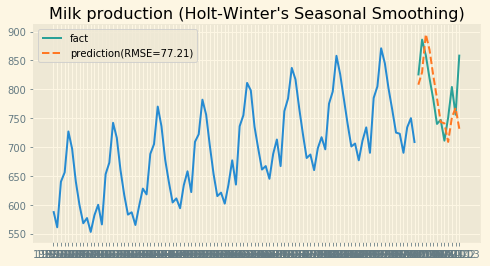

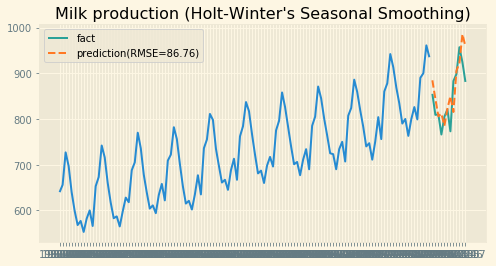

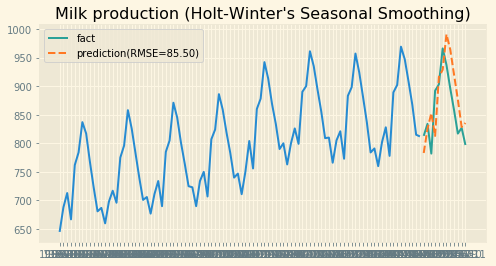

In [178]:
milk_hw_cv = cv_exp(r,n_fold=3, test=0.5, offset=0.5,title='Milk production', \
                    trend='add', seasonal='add', seasonal_periods=12, plot=True)

In [179]:
milk_hw_cv

{'mae': 67.01775175465055,
 'mape': 4.954841229679025,
 'mdape': 4.886638939139327,
 'mse': 6933.2766589871535,
 'rmpse': 5.901955430829624,
 'rmse': 83.15844254245538,
 'rmsle': 0.09796206130193613,
 'smape': 4.934555378966768,
 'smdape': 4.841605121090306}

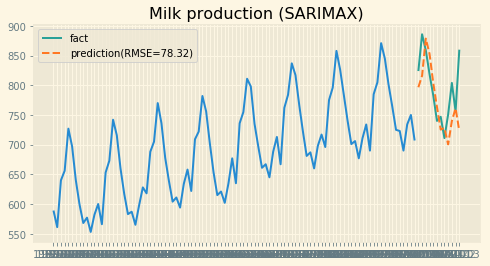

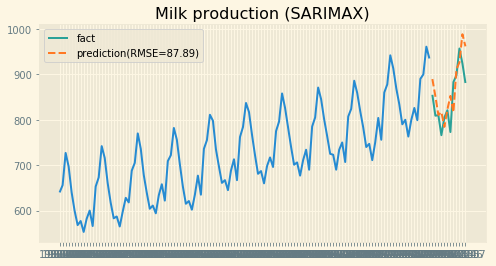

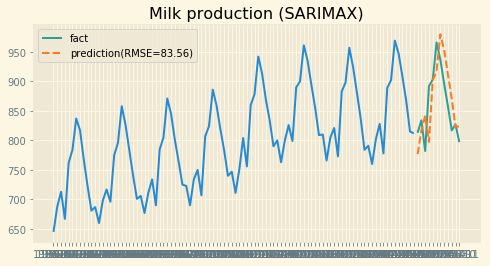

In [180]:
milk_sarimax_cv = cv_sarimax(r, title='Milk production', 
                             n_fold=3, test=0.5, offset=0.5,
                             order=(0,1,0), seasonal_order=(1,1,1,12),
                             enforce_stationarity=True, enforce_invertibility=True,
                             plot=True)

In [181]:
milk_sarimax_cv

{'mae': 67.25759745580585,
 'mape': 4.87389021477025,
 'mdape': 4.251440252510066,
 'mse': 6947.31269467129,
 'rmpse': 5.934000073793982,
 'rmse': 83.25858787218374,
 'rmsle': 0.09857586172856521,
 'smape': 4.894554368980868,
 'smdape': 4.237161955746264}

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to o

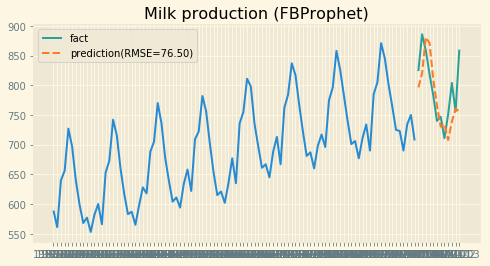

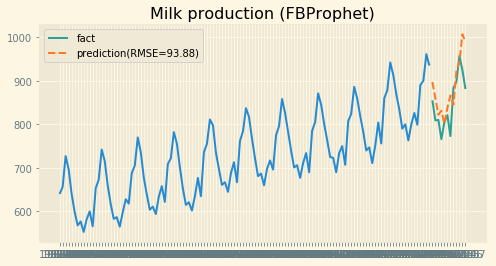

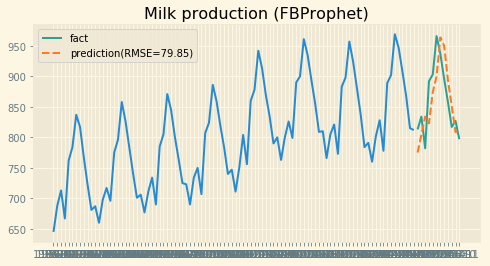

In [24]:
milk_fb_cv = cv_prophet(r,freq='M', title='Milk production',n_fold=3, test=0.5, offset=0.5,
               weekly_seasonality=False, seasonality_mode = 'additive',
               yearly_seasonality=True,
               plot=True)

In [25]:
milk_fb_cv

{'mae': 67.1257902155526,
 'mape': 4.94424538106817,
 'mdape': 4.105081437983513,
 'mse': 7013.647678575177,
 'rmpse': 5.791926168339799,
 'rmse': 83.40829163400149,
 'rmsle': 0.09819843468286522,
 'smape': 4.9177305421407125,
 'smdape': 4.051905443786011}

2) AEP

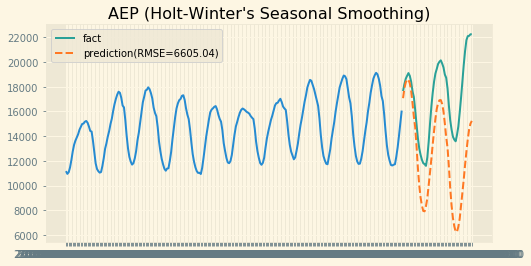

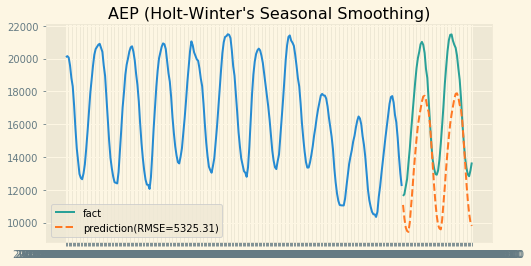

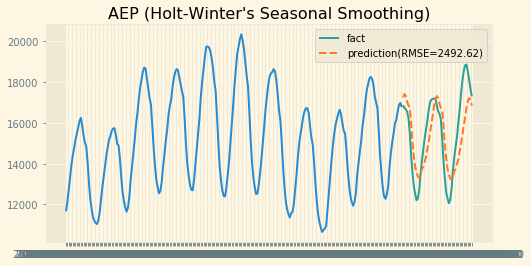

In [116]:
aep_hw_cv = cv_exp(aep,n_fold=3, test=0.1, offset=0.9,title='AEP', \
                    trend='add', seasonal='add', seasonal_periods=24, plot=True)

In [117]:
aep_hw_cv

{'mae': 3954.756411602417,
 'mape': 17.299464511368896,
 'mdape': 17.712345621576386,
 'mse': 26066204.30396751,
 'rmpse': 20.060028281634917,
 'rmse': 4807.655572315701,
 'rmsle': 0.3432816488160489,
 'smape': 20.159580917403996,
 'smdape': 19.660458229778534}

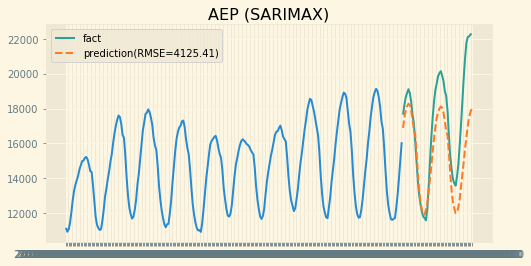

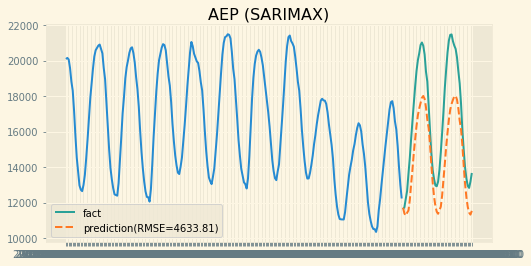

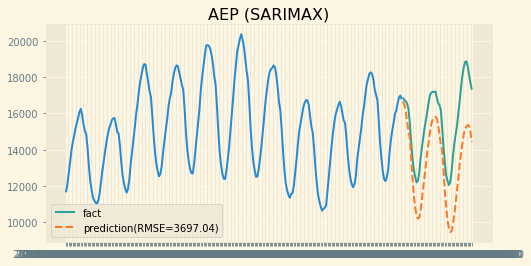

In [118]:
aep_sarimax_cv = cv_sarimax(aep, title='AEP', 
                            n_fold=3, test=0.1, offset=0.9, 
                            order=(1,1,2), seasonal_order=(1,1,1,24),
                            enforce_stationarity=True, enforce_invertibility=True,
                            plot=True)

In [119]:
aep_sarimax_cv

{'mae': 3407.7570586518923,
 'mape': 12.340046096693309,
 'mdape': 12.58143287366611,
 'mse': 17386451.385289256,
 'rmpse': 13.99589190530894,
 'rmse': 4152.088456339567,
 'rmsle': 0.2738495845861127,
 'smape': 13.430181639122223,
 'smdape': 13.464159502948037}

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


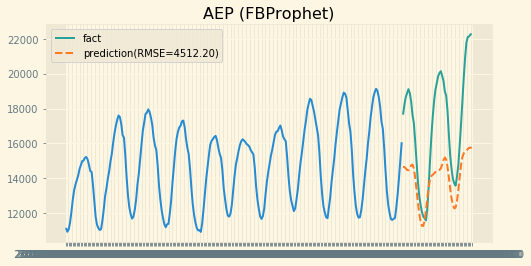

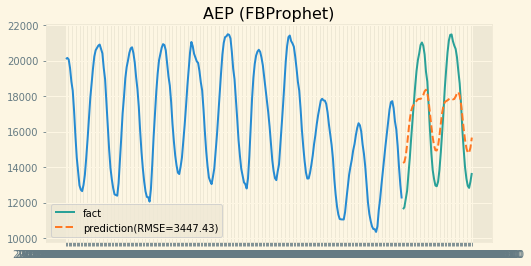

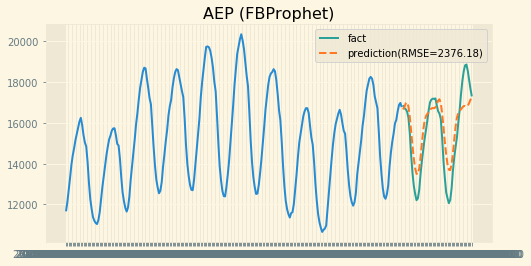

In [30]:
aep_fb_cv = cv_prophet(aep,freq='H', title='AEP',n_fold=3, test=0.1, offset=0.9,
               weekly_seasonality=True, seasonality_mode = 'additive',
               yearly_seasonality=True,
               plot=True)

In [185]:
aep_fb_cv

{'mae': 3173.4845183392486,
 'mape': 13.415546983978166,
 'mdape': 12.843277179161511,
 'mse': 15710171.641384875,
 'rmpse': 15.166519029537307,
 'rmse': 3808.0348664250027,
 'rmsle': 0.24045617167700276,
 'smape': 14.601044244197292,
 'smdape': 13.798620471454674}

3) DJ Index

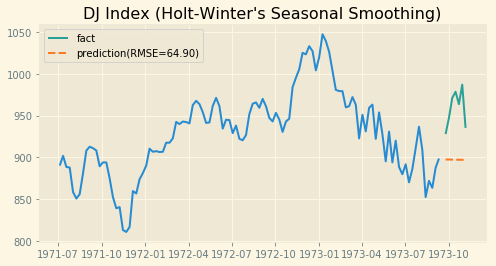

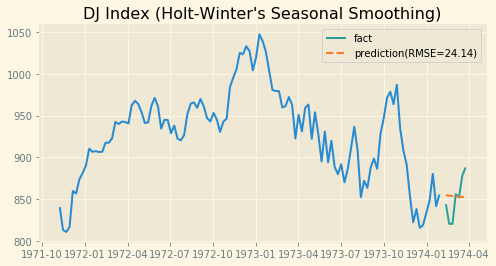

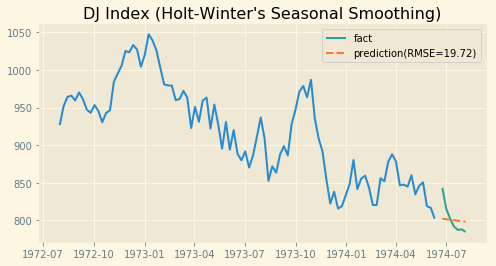

In [128]:
dj_hw_cv = cv_exp(df_dj,n_fold=3, test=0.5, offset=0.65,title='DJ Index', \
                    trend='mul', seasonal='None', seasonal_periods=None, plot=True)

In [129]:
dj_hw_cv

{'mae': 32.314580684532594,
 'mape': 3.5211483480294743,
 'mdape': 3.792391623412596,
 'mse': 1727.8799445757925,
 'rmpse': 3.952690544983374,
 'rmse': 36.25224328106331,
 'rmsle': 0.04066731014288677,
 'smape': 3.600918463146428,
 'smdape': 3.88511274036798}

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


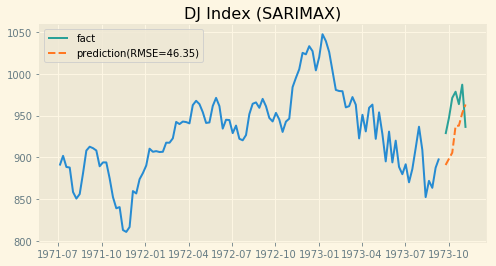

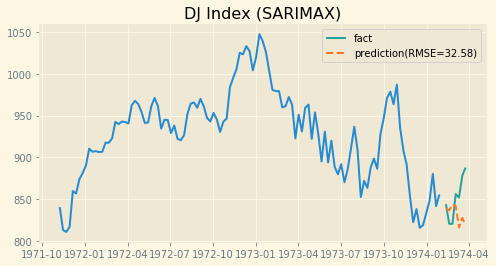

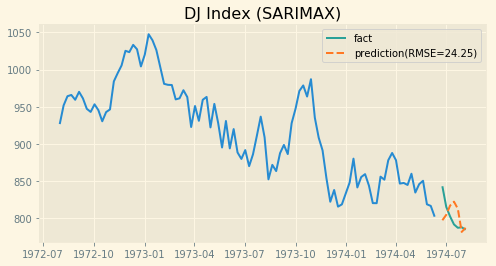

In [130]:
dj_sarimax_cv = cv_sarimax(df_dj, title='DJ Index', 
                            n_fold=3, test=0.5, offset=0.65, 
                            order=(1,1,2), seasonal_order=(1,1,1,24),
                            enforce_stationarity=False, enforce_invertibility=False,
                            plot=True)

In [131]:
dj_sarimax_cv

{'mae': 28.129792558589884,
 'mape': 3.3785684572357866,
 'mdape': 2.8773037738588987,
 'mse': 1266.0421842322128,
 'rmpse': 3.8553432917343264,
 'rmse': 34.394596147716975,
 'rmsle': 0.03920651450719692,
 'smape': 3.4333893859605773,
 'smdape': 2.8860021809544834}

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to o

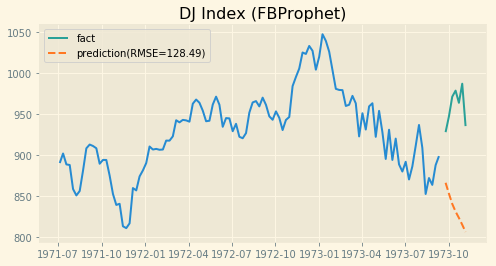

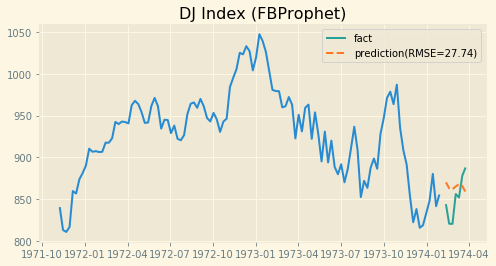

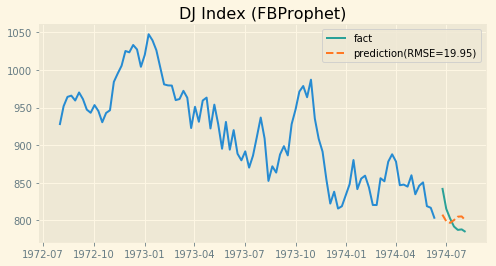

In [26]:
dj_fb_cv = cv_prophet(df_dj,freq='W', title='DJ Index',n_fold=3, test=0.5, offset=0.65,
               weekly_seasonality=True, seasonality_mode = 'additive',
               yearly_seasonality=True,
               plot=True)

In [27]:
dj_fb_cv

{'mae': 55.1510188261125,
 'mape': 6.023242857760511,
 'mdape': 6.316683128370381,
 'mse': 5892.553510456564,
 'rmpse': 6.368040701187399,
 'rmse': 58.72738118099792,
 'rmsle': 0.06689934235810491,
 'smape': 6.336661189037165,
 'smdape': 6.64974378656927}

4) Australian Import

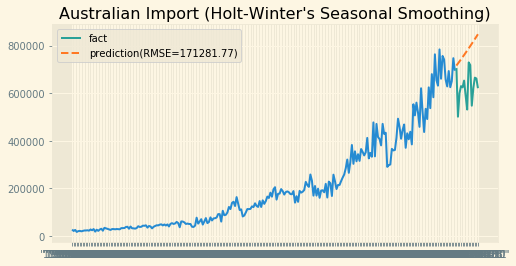

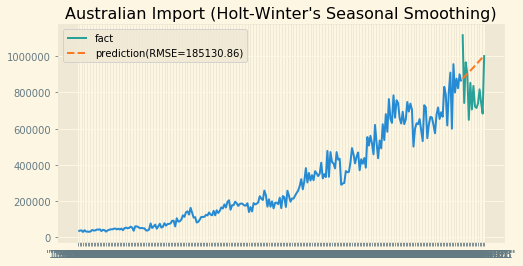

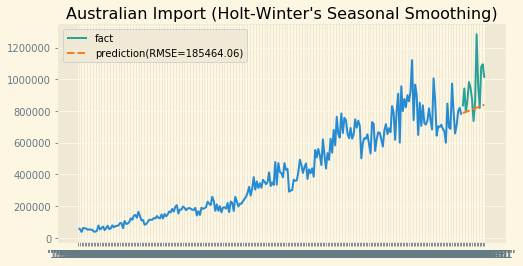

In [134]:
au_hw_cv = cv_exp(df_au,n_fold=3, test=0.5, offset=0.7,title='Australian Import', \
                    trend='mul', seasonal='None', seasonal_periods=None, plot=True)

In [135]:
au_hw_cv

{'mae': 152161.79926717794,
 'mape': 20.444433205755605,
 'mdape': 20.179057825603568,
 'mse': 32669266330.251263,
 'rmpse': 23.856212706739328,
 'rmse': 180625.5645919959,
 'rmsle': 0.222293596292508,
 'smape': 18.87385916877672,
 'smdape': 20.55440050118577}

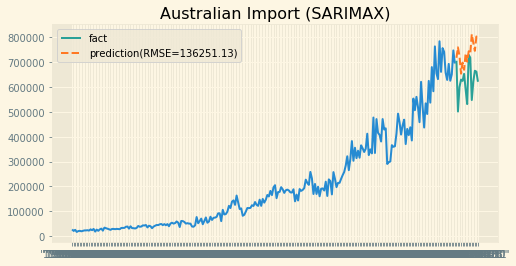

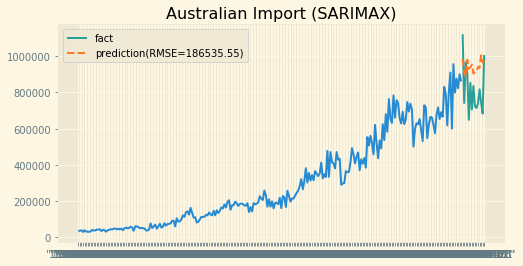

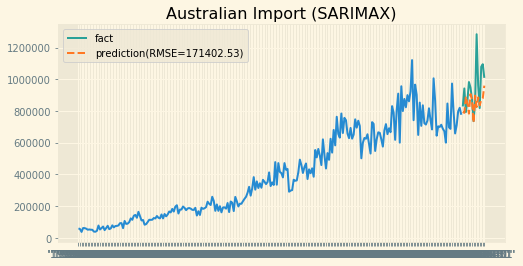

In [136]:
au_sarimax_cv = cv_sarimax(df_au, title='Australian Import', 
                            n_fold=3, test=0.5, offset=0.7, 
                            order=(1,1,2), seasonal_order=(1,1,1,24),
                            enforce_stationarity=True, enforce_invertibility=True,
                            plot=True)

In [137]:
au_sarimax_cv

{'mae': 136781.29143530686,
 'mape': 17.068771253185293,
 'mdape': 16.311502914660757,
 'mse': 27579569690.37974,
 'rmpse': 21.402888073599886,
 'rmse': 164729.7362630482,
 'rmsle': 0.20300041204206032,
 'smape': 15.696066082888867,
 'smdape': 14.868856277789162}

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to o

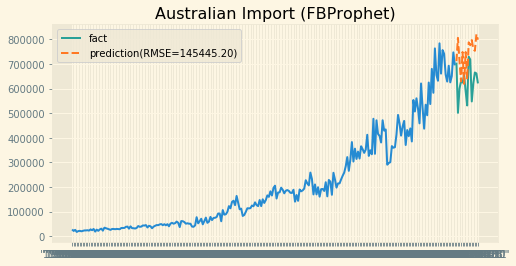

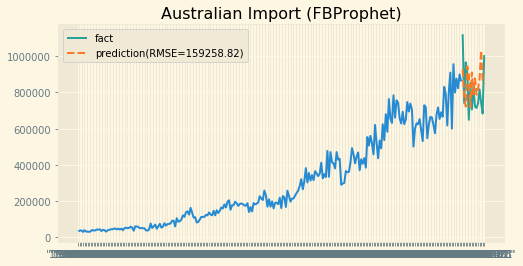

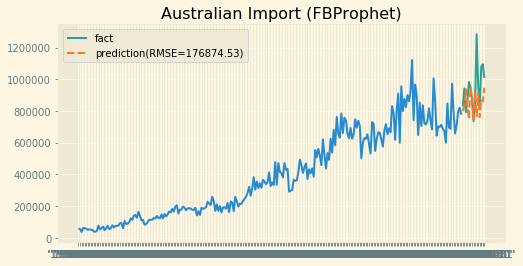

In [28]:
au_fb_cv = cv_prophet(df_au,freq='M', title='Australian Import',n_fold=3, test=0.5, offset=0.7,
               weekly_seasonality=True, seasonality_mode = 'multiplicative',
               yearly_seasonality=True,
               plot=True)

In [29]:
au_fb_cv

{'mae': 130132.73333755665,
 'mape': 16.596238662556463,
 'mdape': 14.28519251588961,
 'mse': 25934092709.37834,
 'rmpse': 20.877682471587686,
 'rmse': 160526.18435318634,
 'rmsle': 0.19780404753689737,
 'smape': 15.757082632893693,
 'smdape': 14.241442758446704}

**Изыскания по кроссвалидации**

1) Встроенная в Prophet.

In [0]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [0]:
train_fb = r.reset_index()
train_fb.columns = ['ds','y']

In [204]:
m = Prophet()
m.fit(train_fb)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [221]:
df_m = cross_validation(m, initial= '2555 days', period = '730 days', horizon = '180 days')

INFO:fbprophet:Making 4 forecasts with cutoffs between 1969-06-05 00:00:00 and 1975-06-04 00:00:00
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

In [0]:
df_p = performance_metrics(df_m,rolling_window=0.1)


In [227]:
df_p.head(7)

horizon         mse       rmse        mae      mape  coverage
6  26 days  231.618397  15.219014  15.131567  0.018072       0.0
12 27 days  222.875369  14.929011  14.799650  0.016930       0.0
18 27 days  105.536072  10.273075   9.819393  0.011081       0.5
1  57 days  214.207752  14.635838  13.174717  0.016589       0.5
7  57 days  433.762646  20.826969  20.789979  0.026002       0.0
13 58 days  370.335468  19.244102  19.004703  0.022753       0.0
19 58 days  187.998156  13.711242  13.482017  0.015947       0.0

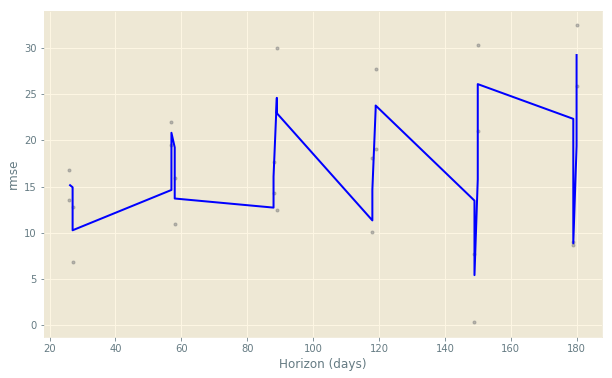

In [228]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_m, metric='rmse')

In [229]:
df_m.head(10)

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1969-07-01  787.497570  780.821485  793.693121  801 1969-06-05
1 1969-08-01  744.450756  738.134252  750.300881  764 1969-06-05
2 1969-09-01  707.297833  700.759679  713.705775  725 1969-06-05
3 1969-10-01  712.918615  706.563853  719.166994  723 1969-06-05
4 1969-11-01  689.655781  683.200578  695.778075  690 1969-06-05
5 1969-12-01  724.957914  718.249478  732.067858  734 1969-06-05
6 1971-07-01  852.239297  843.107900  861.237273  869 1971-06-05
7 1971-08-01  811.969286  802.547852  820.869120  834 1971-06-05
8 1971-09-01  775.744911  766.698884  784.723021  790 1971-06-05
9 1971-10-01  781.896770  772.590593  790.833753  800 1971-06-05

Итог по кроссвалидации в Prophet. Как я понял, основная задача - подобрать оптимальный горизонт для моделирования и тестирования.  Сбор итоговых метрик очень не удобен. 

В качестве входных параметров -  горизонт прогнозирования (horizon), init- определяет выборку для обучения (огрничена init и  начальной точкой выборки), period  -  период через который необходимо взять новую точку init.   

Решил сделать несколько вариантов кросс-валидации, чтобы выбрать наиболее удобный для корректировки метрик по текущим бенчмаркам.

**A)**  Вся  выборка делится на n равных и последователных  фолдов, в каждом из которых есть train, test, val подвыборки. skip  - позволяет сделть временной отступ от train-val  выборок, чтобы получить качество на данных, кторые отстоят на каком-то временном лаге. 

In [0]:
def train_test_val_split(df, title='', n_fold = 3, train=0.8, test=0.2, val=0.0, skip=0):
    if abs(train + test + val - 1) > 0.000000001:
        print('Please, point correct size of train/test/valid samples!!')
    else:
        N = df.shape[0]
        T  = np.floor((N)/n_fold)
        train_start_idx = [0 + k * T for k in range(n_fold)]
        train_finish_idx = [0 + np.floor(T * train) + T * k  for k in range(n_fold)]

        val_start_idx = []
        val_finish_idx = []

        if val:
            val_start_idx = [0 + k * T + np.floor(T * train) + 1 for k in range(n_fold)]
            val_finish_idx = [0 + np.floor(T * train) + np.floor(T * val)+ T * k for k in range(n_fold)]
   
      

        test_start_idx = []
        test_finish_idx = []

        if test:
            test_start_idx = [0 + k * T + np.floor(T * train) + np.floor(T * val) + skip + 1 for k in range(n_fold)]
            test_finish_idx = [0 + T + T * k -1  \
                               for k in range(n_fold)]
        
        train_idx = list(zip(map(int,train_start_idx),map(int,train_finish_idx)))
        test_idx = list(zip(map(int,test_start_idx),map(int,test_finish_idx)))
        val_idx = list(zip(map(int,test_start_idx),map(int,val_finish_idx)))
        train_df = [df.iloc[train_idx[i][0]:train_idx[i][1]] for i in range(len(train_idx))]
        test_df = [df.iloc[test_idx[i][0]:test_idx[i][1]] for i in range(len(test_idx))]
        val_df = [df.iloc[val_idx[i][0]:val_idx[i][1]] for i in range(len(val_idx))]
        
        if val:
            return list(zip(train_df, test_df, val_df))
        else:
            return list(zip(train_df, test_df))

In [0]:
def cv_exp(tts, title='', trend='add', seasonal='add', seasonal_periods=12, plot=False):
    res = {}
    rmse = []
    mse = []
    mae = []
    rmsle = []
    mape = []
    mdape = []
    smape = []
    smdape = []
    rmpse = []
    for data in tts:
        model = ExponentialSmoothing(data[0].values, trend=trend, seasonal=seasonal, 
                                     seasonal_periods=seasonal_periods)
        fit = model.fit()
        pred = fit.predict(data[0].shape[0], data[0].shape[0] + data[1].shape[0] -1)
        rmse.append(metrics.rmse(pred, data[1].values))
        mse.append(metrics.mse(data[1], pred))
        mae.append(metrics.mae(data[1], pred))
        rmsle.append(metrics.rmsle(data[1], pred))
        mape.append(MAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        mdape.append(MdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smape.append(sMAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smdape.append(sMdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        rmpse.append(RMSPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        if plot:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.plot(data[0].index[data[0].shape[0] - 250:], data[0].values[data[0].shape[0] - 250:]);
            ax.plot(data[1].index, data[1].values, label='fact');
            ax.plot(data[1].index, pred, linestyle='--', color='#ff7823', 
                    label="prediction(RMSE={:0.2f})".format(metrics.rmse(pred, data[1].values)));
            ax.legend();
            ax.set_title(title  + " (Holt-Winter's Seasonal Smoothing)");
        res['rmse'] = np.mean(rmse)
        res['mse'] = np.mean(mse)
        res['mae'] = np.mean(mae)
        res['rmsle'] = np.mean(rmsle)
        res['mape'] = np.mean(mape)
        res['mdape'] = np.mean(mdape)
        res['smape'] = np.mean(smape)
        res['smdape'] = np.mean(smdape)
        res['rmpse']  = np.mean(rmpse)
    return res

In [0]:
def cv_sarimax(tts, title='', order=(0,1,0), seasonal_order=(1,1,1,12),
               enforce_stationarity=False, enforce_invertibility=False,
               plot=False):
    res = {}
    rmse = []
    mse = []
    mae = []
    rmsle = []
    mape = []
    mdape = []
    smape = []
    smdape = []
    rmpse = []
    for data in tts:
             
        model = sm.tsa.statespace.SARIMAX(data[0].values, 
                                          order=order, 
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=enforce_stationarity,
                                          enforce_invertibility=enforce_invertibility
                                         )
        fit = model.fit()
        pred = fit.predict(data[0].shape[0], data[0].shape[0] + data[1].shape[0] -1)
        rmse.append(metrics.rmse(pred, data[1].values))
        mse.append(metrics.mse(data[1], pred))
        mae.append(metrics.mae(data[1], pred))
        rmsle.append(metrics.rmsle(data[1], pred))
        mape.append(MAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        mdape.append(MdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smape.append(sMAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        smdape.append(sMdAPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        rmpse.append(RMSPE(np.array(data[1]).flatten(),np.array(pred).flatten()))
        if plot:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.plot(data[0].index[data[0].shape[0] - 250:], data[0].values[data[0].shape[0] - 250:]);
            ax.plot(data[1].index, data[1].values, label='fact');
            ax.plot(data[1].index, pred, linestyle='--', color='#ff7823', 
                    label="prediction(RMSE={:0.2f})".format(metrics.rmse(pred, data[1].values)));
            ax.legend();
            ax.set_title(title + " (SARIMAX)");
        res['rmse'] = np.mean(rmse)
        res['mse'] = np.mean(mse)
        res['mae'] = np.mean(mae)
        res['rmsle'] = np.mean(rmsle)
        res['mape'] = np.mean(mape)
        res['mdape'] = np.mean(mdape)
        res['smape'] = np.mean(smape)
        res['smdape'] = np.mean(smdape)
        res['rmpse']  = np.mean(rmpse)
    return res

In [0]:
lll = train_test_val_split(r,n_fold=3,train=0.8, test=0.2, skip=0)

84.7675373144475

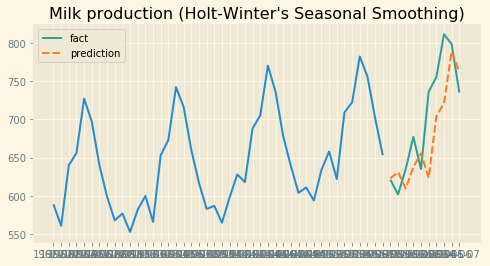

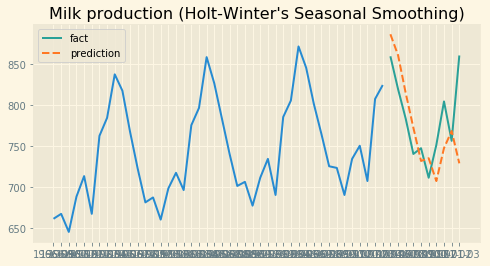

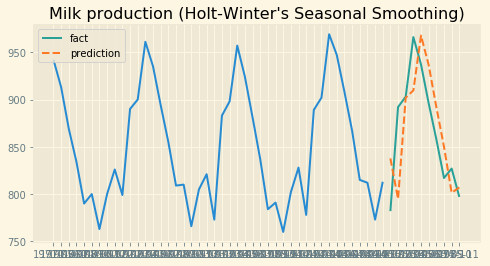

In [105]:
np.mean(cv_exp(lll, seasonal_periods=12))

In [0]:
rrr = train_test_val_split(df_au,n_fold=3,train=0.8, test=0.2, skip=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:69: RuntimeWarning: overflow encountered in double_scalars
  l[i] = (y_alpha[i - 1]) + (alphac * (l[i - 1] * b[i - 1]**phi))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:70: RuntimeWarning: invalid value encountered in double_scalars
  b[i] = (beta * (l[i] / l[i - 1])) + (betac * b[i - 1]**phi)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:71: RuntimeWarning: overflow encountered in multiply
  return sqeuclidean(l * b**phi, y)


109788.8514437292

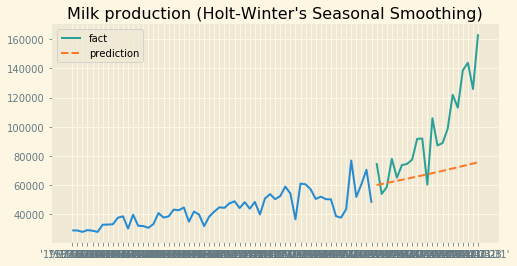

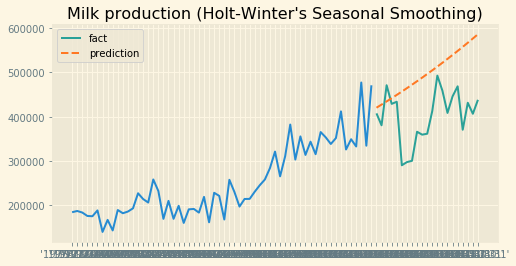

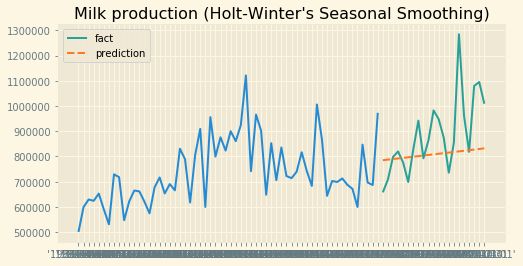

In [111]:
np.mean(cv_exp(rrr, seasonal=None, trend='mul'))

In [0]:
ppp = train_test_val_split(df_dj,n_fold=3,train=0.8, test=0.2, skip=0)

45.47179211052589

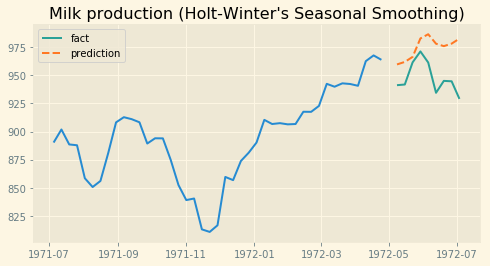

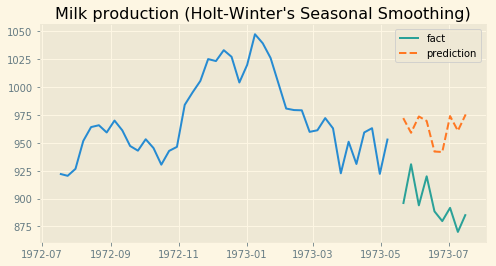

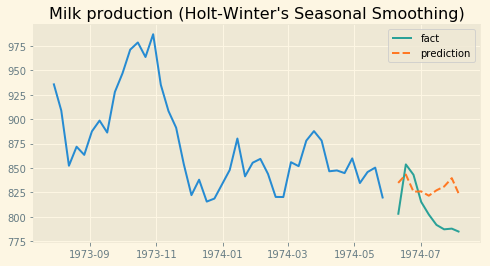

In [115]:
np.mean(cv_exp(ppp, seasonal_periods=6, trend='add'))

Основной вывод по данному типу -  сложилось впечатление, что данных мало и для фолдов могут быть принципиально разные участки данных (где-то начинается подъем, где-то стагнация) и разброс в метриках (в т.ч. визуально) существенный. 

**Б)** 
Второй подход  основан на статьях: 

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

https://otexts.com/fpp2/accuracy.html

Он похож на тот, что реализован в Prophet. Я реализовал так - бью на фолды  и потом сначала первый фолд train+test, потом первый и второй фолд - train-test....

In [0]:
def train_test_val_split_v2(df,n_fold=3, test=0.1):
    N = df.shape[0]
    T  = np.floor((N)/n_fold)
    train_start_idx = [0  for k in range(n_fold)]
    train_finish_idx = [0 + k * T - np.floor(T * test) + T  for k in range(n_fold)]
    
    test_start_idx = [0 + k * T - np.floor(T * test) + T + 1 for k in range(n_fold)]
    test_finish_idx = [0 + (k + 1) * T - 1 for k in range(n_fold)]
     
    train_idx = list(zip(map(int,train_start_idx),map(int,train_finish_idx)))
    test_idx = list(zip(map(int,test_start_idx),map(int,test_finish_idx)))
    
    train_df = [df.iloc[train_idx[i][0]:train_idx[i][1]] for i in range(len(train_idx))]
    test_df = [df.iloc[test_idx[i][0]:test_idx[i][1]] for i in range(len(test_idx))]
    
    return list(zip(train_df, test_df))

In [0]:
uuu = train_test_val_split_v2(df_au,n_fold=3, test=0.2)

114186.93058128857

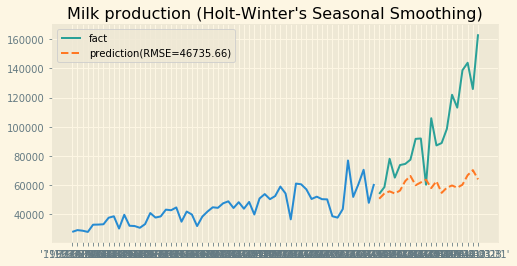

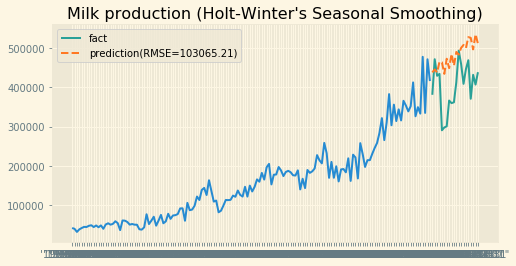

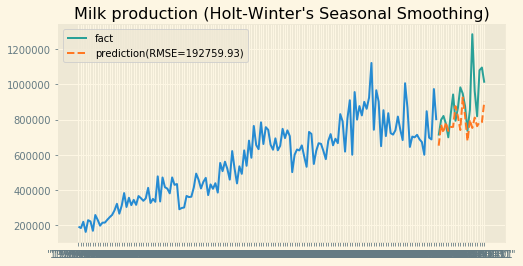

In [22]:
np.mean(cv_exp(uuu, seasonal_periods=12))

Чуть лучше. Но остается проблема различия по поведению временного ряда в фолдах. Дополнительно,  в первом фолде может быть мало данных. Поэтому брать среднее тоже пока не очень круто.

Для того, чтобы преодолеть эту проблему, ввел оффсет - т.е. какой процент истории мы берем во все выборки для обучения. Далее оставшаяся часть делиться на n-фолдов  train-test. При такой реализации можно заведомо использовать большой кусок истории для обучения, а сравниваемые модели будут видеть "похожие" ряды. В этом случае усреднять более разумно. 

В чем преимущество?Используется стандартная техника кросс-валидации для временных рядов (такого train-test split  базового нет в питоне ) + можно явно задать количество фолдов и долю test. Сигнатура фейсбучной кросс-валидации не позволяет явно задать числов фолдов, по которому хочется усреднить метрики.

In [0]:
def train_test_val_split_v3(df,n_fold=3, test=0.5, offset = 0.7):
    
    N = df.shape[0]
    shift = np.floor(N*offset)
    T  = np.floor((N - shift) /n_fold)
    
    train_start_idx = [0  for k in range(n_fold)]
    train_finish_idx = [0 + shift + k * T - np.floor(T * test) + T  for k in range(n_fold)]
    
    test_start_idx = [0 + shift + k * T - np.floor(T * test) + T + 1 for k in range(n_fold)]
    test_finish_idx = [0 + shift + (k + 1) * T - 1 for k in range(n_fold)]
     
    train_idx = list(zip(map(int,train_start_idx),map(int,train_finish_idx)))
    test_idx = list(zip(map(int,test_start_idx),map(int,test_finish_idx)))
    
    train_df = [df.iloc[train_idx[i][0]:train_idx[i][1]] for i in range(len(train_idx))]
    test_df = [df.iloc[test_idx[i][0]:test_idx[i][1]] for i in range(len(test_idx))]
    
    return list(zip(train_df, test_df))

In [0]:
qqq = train_test_val_split_v3(df_au, offset=0.75)

147801.07696610558

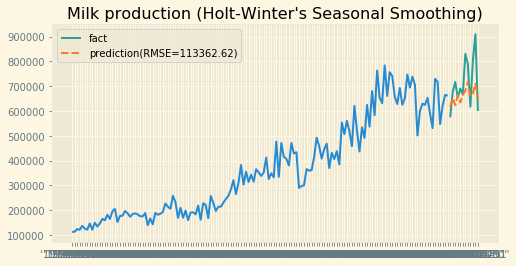

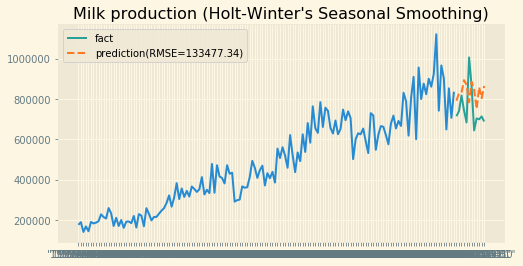

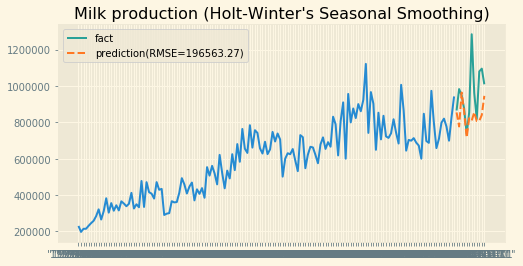

In [51]:
np.mean(cv_exp(qqq, seasonal_periods=12))

In [0]:
yyy = train_test_val_split_v3(df_dj, offset=0.7)

{'mae': 44.94783561801424,
 'mape': 5.12057428185129,
 'mdape': 5.581741321501316,
 'mse': 3024.6488871702313,
 'rmpse': 5.7087446508914494,
 'rmse': 51.98591467274656,
 'rmsle': 0.060727157807993974,
 'smape': 5.089397236852612,
 'smdape': 5.565880419635483}

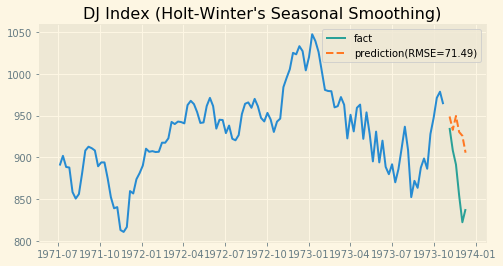

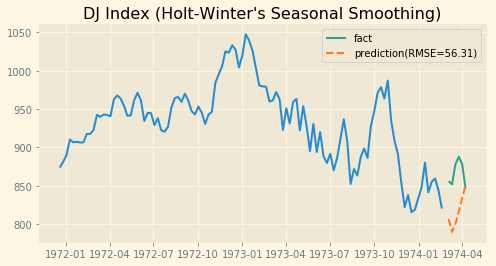

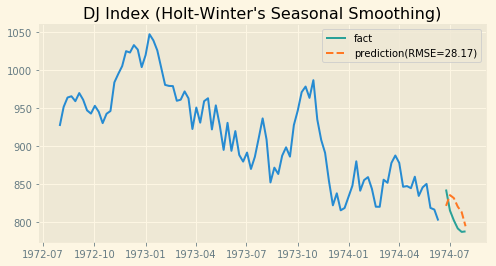

In [101]:
cv_exp(yyy, seasonal_periods=12, trend='add', title='DJ Index', plot=True)

In [74]:
cv_exp(yyy,model_dj, seasonal_periods=12, trend='add')

{'mae': 72.42324985867312,
 'mape': 8.08702488955383,
 'mdape': 9.10073502889952,
 'mse': 7909.250460137639,
 'rmpse': 8.863317010831489,
 'rmse': 78.65803557759962,
 'rmsle': 0.08812827021341073,
 'smape': 7.589564490786796,
 'smdape': 8.538500184274923}

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'mae': 61.08381008553903,
 'mape': 7.207903378199859,
 'mdape': 7.609404345049687,
 'mse': 5869.230482462786,
 'rmpse': 7.786559989032292,
 'rmse': 66.14945305314498,
 'rmsle': 0.075133592581533,
 'smape': 7.005203214510032,
 'smdape': 7.3757345817220274}

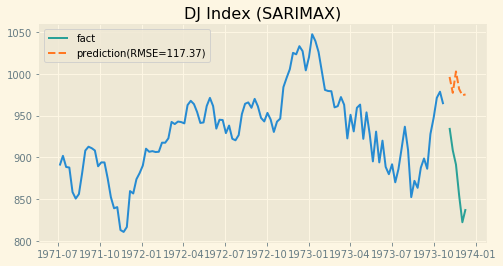

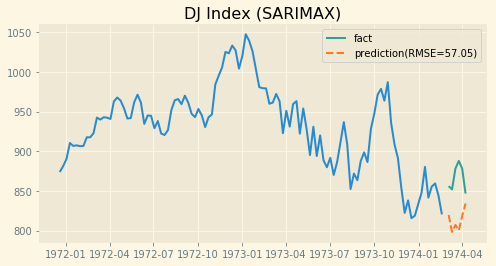

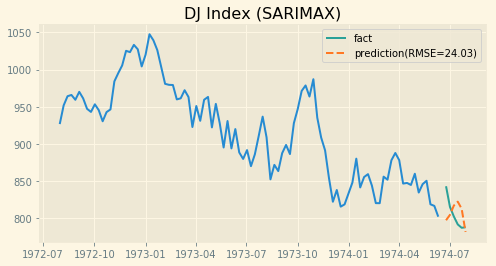

In [102]:
cv_sarimax(yyy, order=(1,1,2), seasonal_order=(1,1,1,24), plot=True, title='DJ Index')

В итоге остановился на данном варианте.